In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.style.use('fivethirtyeight')
sns.set_context("notebook")

Let's start by loading the California baby names again.

In [ ]:
import urllib.request
import os.path
import zipfile

data_url = "https://www.ssa.gov/oact/babynames/state/namesbystate.zip"
local_filename = "babynamesbystate.zip"
if not os.path.exists(local_filename): # if the data exists don't download again
    with urllib.request.urlopen(data_url) as resp, open(local_filename, 'wb') as f:
        f.write(resp.read())

zf = zipfile.ZipFile(local_filename, 'r')

ca_name = 'CA.TXT'
field_names = ['State', 'Sex', 'Year', 'Name', 'Count']
with zf.open(ca_name) as fh:
    babynames = pd.read_csv(fh, header=None, names=field_names)

babynames.sample(5)

## Goal 1: Find the most popular baby name in California in 2018 ##

In [ ]:
babynames["Year"]

In [ ]:
babynames[babynames["Year"] == 2018].sort_values(
    by = "Count", ascending = False).head(5)

## Goal 2: Find all rows in which the name starts with J ## 

### Approach 1: Combine lecture 4 syntax with CS61A/CS88 ideas.

In [ ]:
babynames["Name"].head(10)

In [ ]:
starts_with_j = [x[0] == 'J' for x in babynames["Name"]]
starts_with_j

In [ ]:
starts_with_j = [x[0] == 'J' for x in babynames["Name"]]
babynames[starts_with_j]

In [ ]:
j_names = babynames[ [x[0] == 'J' for x in babynames["Name"]] ]
j_names

### Approach 2: Use the Series.str methods.

In [ ]:
babynames["Name"].str.startswith('J').head(10)

In [ ]:
babynames[babynames["Name"].str.startswith('J')]

In [ ]:
babynames[babynames["Name"].str.contains('ani')].sample(5)

In [ ]:
babynames["Name"].str.split('a').head(5)

In-lecture challenge: Try to write a line of code that creates a list (or Series or array) of all names that end with “ert”.

In [ ]:
babynames[babynames["Name"].str.endswith('ert')]["Name"].unique()

## Goal 3: Sort names by their length.

Suppose we want to sort all rows by the length of the name.

As before, there are ways to do this using only Lecture 4 content. For example, the montrosity below was concocted during the Sp19 version of this class.

In [ ]:
babynames.iloc[[i for i, m in sorted(enumerate(babynames['Name']), key=lambda x: -len(x[1]))]].head(5)

### Approach 1: Create a temporary column.

Create a new series of only the lengths. Then add that series to the dataframe as a column. Then sort by that column. Then drop that column.

In [ ]:
#create a new series of only the lengths
babyname_lengths = babynames["Name"].str.len()

#add that series to the dataframe as a column
babynames["name_lengths"] = babyname_lengths
babynames.head(5)

In [ ]:
#sort by the temporary column
babynames = babynames.sort_values(by = "name_lengths", ascending=False)
babynames.head(5)

In [ ]:
#drop the temporary column
babynames = babynames.drop("name_lengths", axis = 1)
babynames.head(5)

### `map` ###

We can also use the Python map function if we want to use an arbitrarily defined function. Suppose we want to sort by the number of occurrences of "dr" plus the number of occurences of "ea".

In [ ]:
def dr_ea_count(string):
    return string.count('dr') + string.count('ea')

#create the temporary column
babynames["dr_ea_count"] = babynames["Name"].map(dr_ea_count)

#sort by the temporary column
babynames = babynames.sort_values(by = "dr_ea_count", ascending=False)

#drop that column
babynames = babynames.drop("dr_ea_count", axis = 1)
babynames.head(5)

In [ ]:
babynames.head(5)

### Approach 2: Generate an index sorted in the desired order.

In [ ]:
#let's start over by first scrambling the order of babynames
babynames = babynames.sample(frac=1)
babynames.head(5)

Another approach is to take advantage of the fact that .loc can accept an index. That is:
 + df.loc[idx] returns df with its rows in the same order as the given index.
 + Only works if the index exactly matches the DataFrame.

The first step was to create a sequence of the lengths of the names.

In [ ]:
name_lengths = babynames["Name"].str.len()
name_lengths.head(5)

The next step is to sort the new series we just created.

In [ ]:
name_lengths_sorted_by_length = name_lengths.sort_values()
name_lengths_sorted_by_length.head(5)

Next, we pass the index of the sorted series to the loc method of the original dataframe.

In [ ]:
index_sorted_by_length = name_lengths_sorted_by_length.index
index_sorted_by_length

In [ ]:
babynames.loc[index_sorted_by_length].head(5)

Note we can also do this all in one line:

In [ ]:
babynames.loc[babynames["Name"].str.len().sort_values().index].head(5)

### Goal 4: Name whose popularity has changed the most. 

First we need to define change in popularity. 

For the purposes of lecture, let’s stay simple and use the AMMD (absolute max/min difference): max(count) - min(count). 

To make sure we understand this quantity, let's consider the name Jennifer.

In [ ]:
jennifer_counts = babynames[babynames['Name']=='Jennifer']["Count"]
jennifer_counts.head(5)

The AMMD for Jennifer is 6,061, as seen below:

In [ ]:
max(jennifer_counts) - min(jennifer_counts)

In [ ]:
def ammd(series):
    return max(series) - min(series)

In [ ]:
ammd(jennifer_counts)

In [ ]:
ammd(babynames[babynames['Name']=='Jessica']["Count"])

### Use groupby.agg

Now we can use the very powerful groupby.agg operation, which allows us to simply and efficiently compute what we want.

In [ ]:
babynames.groupby("Name").agg(max).head(5)

In [ ]:
babynames.groupby("Name").agg(ammd).head(5)

Note that the result includes both a Year and Count column. The Count column is what we want, namely the AMMD for the name in that row. To check your understanding, try to figure out what the Year column represents.

## Some Additional Groupby Puzzles

Groupby puzzle #1: To test your understanding, try to interpret the result of the code below.

In [ ]:
babynames.head(5)

In [ ]:
babynames.groupby("Year").agg(ammd).plot();

For reference, the first 5 values from the plot above are:

In [ ]:
babynames.groupby("Year").agg(ammd).head(5)

#### groupby Puzzle #2

In [ ]:
elections = pd.read_csv("elections.csv")
elections.sample(5)

We have to be careful when using aggregation functions. For example, the code below might be misinterpreted to say that Woodrow Wilson ran for election in 2016. Why is this happening?

elections.groupby("Party").agg(max).head(10)

### groupby puzzle #3

Inspired by above, try to predict the results of the groupby operation shown. The answer is below the image.

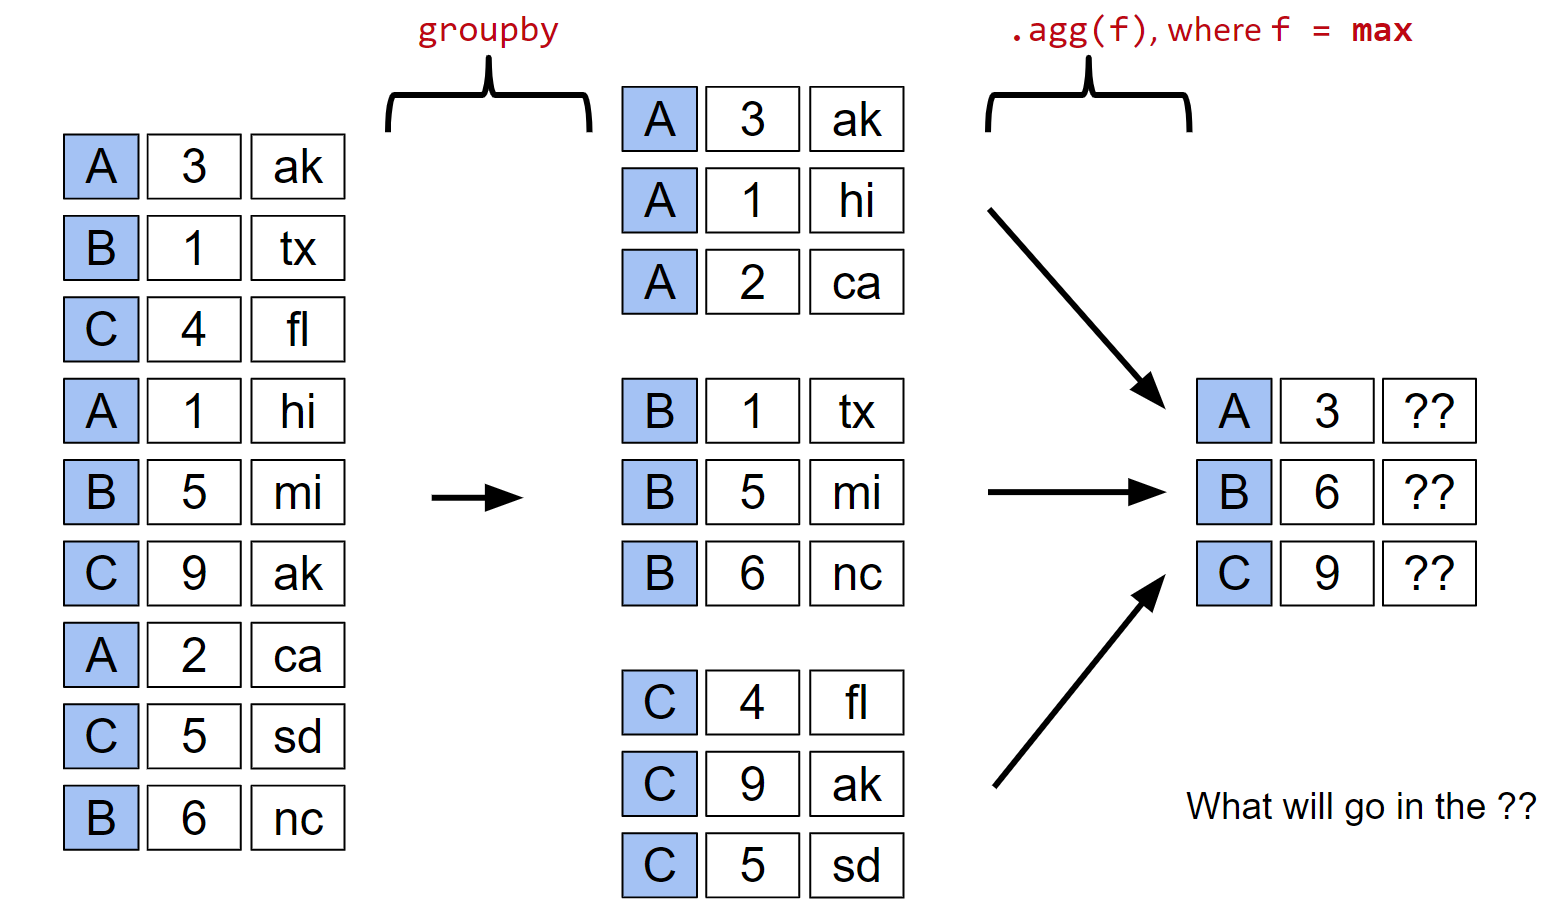

The top ?? will be "hi", the second ?? will be "tx", and the third ?? will be "sd". 

### groupby puzzle #4

Next we'll write code that properly returns the best result by each party. That is, each row should show the Year, Candidate, Popular Vote, Result, and % for the election in which that party saw its best results (rather than mixing them as in the example above).

In [ ]:
elections_sorted_by_percent = elections.sort_values("%", ascending=False)
elections_sorted_by_percent.head(5)

In [ ]:
#def get_first(s):
#    return s.iloc[0]
    
elections_sorted_by_percent = elections.sort_values("%", ascending=False)
elections_sorted_by_percent.groupby("Party").agg(lambda x : x.iloc[0])

## Other groupby Features

### groupby.size()

In [ ]:
elections.groupby("Party")

In [ ]:
#size returns a Series giving the size of each group
elections.groupby("Party").size().head(15)

### groupby.filter()

In [ ]:
# filter gives a copy of the original DataFrame where row r is included
# if its group obeys the given condition
#
# Note: Filtering is done per GROUP, not per ROW.
elections.groupby("Year").filter(lambda sf: sf["%"].max() < 45)

In [ ]:
for n, g in elections.groupby("Party"):
    print(n)
    display(g)

### groupby.sum(), groupby.mean(), etc.

As an alternative to groupby.agg(sum), we can also simply do groupby.sum().

In [ ]:
elections.groupby("Year").agg(sum).head()

In [ ]:
elections.groupby("Year").sum().head()

The same applies for many other common operations.

In [ ]:
elections.groupby("Year").agg(max).head()

In [ ]:
elections.groupby("Year").max().head()

In [ ]:
#elections.groupby("Year").mean().head()
#elections.groupby("Year").median().head()
elections.groupby("Year").max().head()

It is possible to group a DataFrame by multiple features. For example, if we group by Year and Sex we get back a DataFrame with the total number of babies of each sex born in each year.

In [ ]:
babynames.groupby(["Year", "Sex"]).agg(sum).head(6)

In [ ]:
babynames.groupby(["Sex", "Year"]).agg(sum).head(6)

In [ ]:
babynames.head(10)

In [ ]:
babynames.groupby(["Count", "Year", "Sex"]).agg(sum).head(6)

The DataFrame resulting from the aggregation operation is now multi-indexed. That is, it has more than one dimension to its index. We will explore this in next week's exercises.

## Pivot Tables ##

### Goal 5: Finding the number of babies born in each year of each sex.

Suppose we want to build a table showing the total number of babies born of each sex in each year. One way is to groupby using both columns of interest.

In [ ]:
babynames.groupby(["Year", "Sex"]).agg(sum).head(6)

A more natural approach is to use a pivot table (like we saw in data 8).

In [ ]:
babynames.head(5)

In [ ]:
babynames_pivot = babynames.pivot_table(
    index='Year', # the rows (turned into index)
    columns='Sex', # the column values
    values='Count', # the field(s) to processed in each group
    aggfunc=sum, # group operation
)
babynames_pivot.head(6)

In [ ]:
babynames_pivot2 = babynames.pivot_table(
    index='Year', # the rows (turned into index)
    columns='Sex', # the column values
    values=['Count', 'Name'], # the field(s) to processed in each group
    aggfunc=np.max, # group operation
)
babynames_pivot2.head(6)

The basic idea behind pivot tables is shown in the image below.

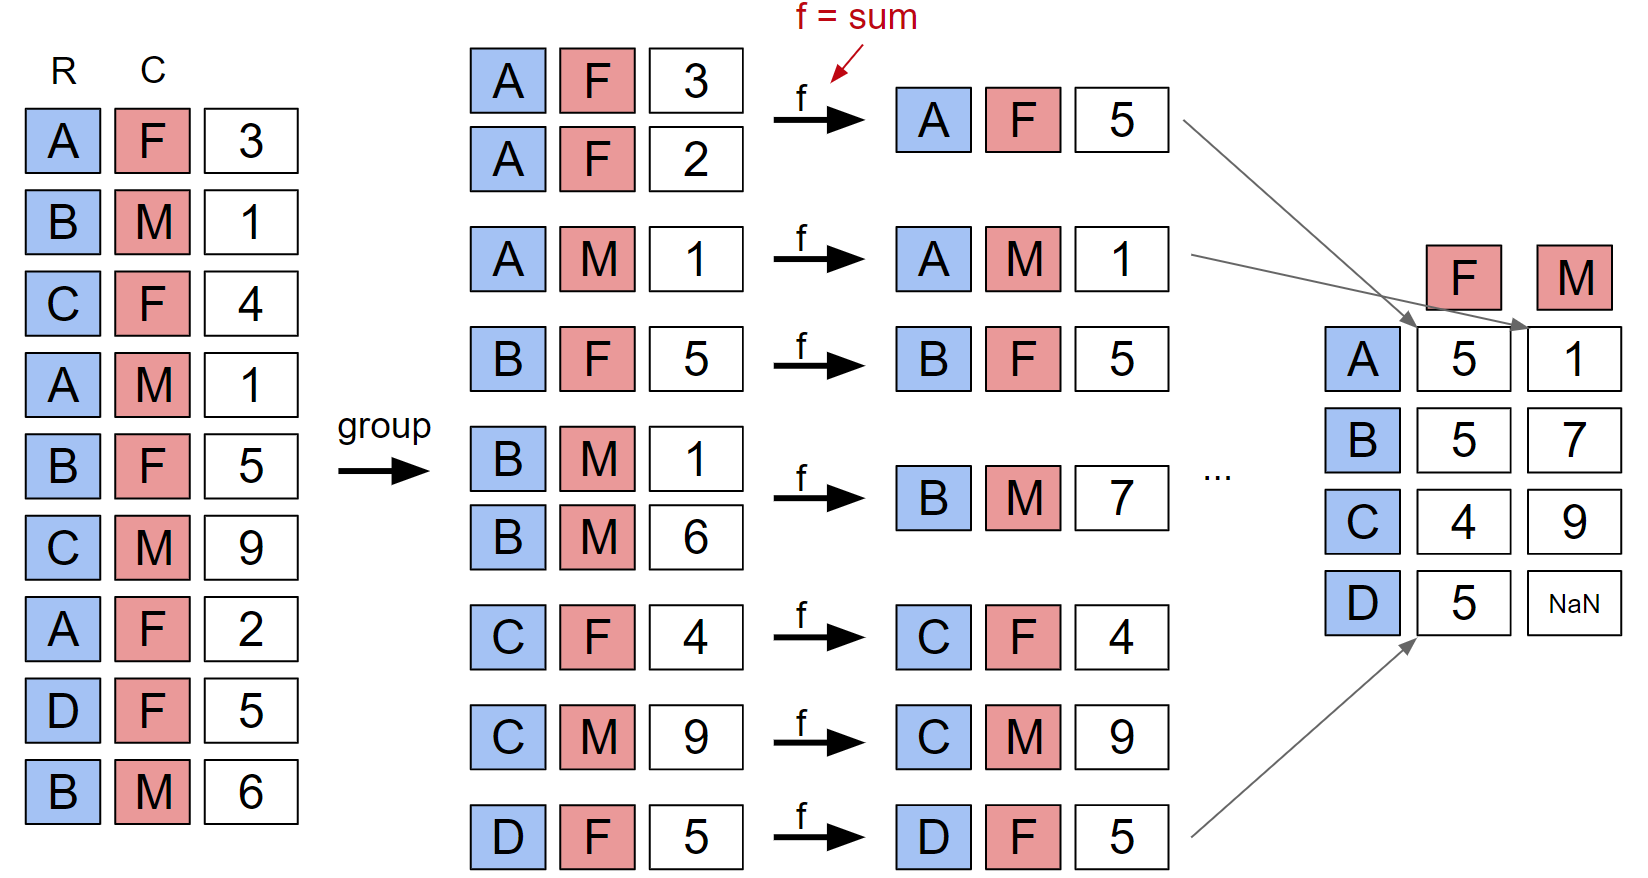

### Extra Groupby Puzzle

### groupby puzzle #5:  More careful look at the most popular 2018 name in California.

In Goal 1, we didn't take into account the unlikely possibility that the most popular name was actually spread across both birth sexes. For example, what if in the table below it turns out that there were 300 female Noahs born in CA in 2018. In that case, Noah would actually be the most popular.

Since our queries are getting pretty long, I've stuck them inside parentheses which allows us to spread them over many lines.

In [ ]:
(
babynames[babynames["Year"] == 2018]
    .sort_values(by = "Count", ascending = False)
    .head(5)
)

Try to add a single line to the operation above so that each row represents the sum of male and female babies born in 2018 with that name. To do this, fill in the ??? below.

In [ ]:
(
babynames[babynames["Year"] == 2018]
    #.???
    .sort_values(by = "Count", ascending = False)
    .head(5)
)

In [ ]:
def ammd2(L):
    return max(L) - min(L)

print(ammd2([1, 2, 3, 4, 5]))

In [ ]:
ammd2 = lambda L: max(L) - min(L)
print(ammd2([1, 2, 3, 4, 5]))